# Polarized rendering

## Overview

In spirit, this example is similar to [Mitsuba quickstart][1] but we'll highlight a few things to keep in mind regarding polarization-aware rendering in Mitsuba 3. 🕶


<div class="admonition important alert alert-block alert-success">

🚀 **You will learn how to:**
    
<ul>
  <li>Build a scene with polarization support in mind.</li>
  <li>Render a scene and output the complete polarization state of light.</li>
  <li>Visualize the output.</li>
</ul>
    
</div>

[1]: https://mitsuba.readthedocs.io/en/latest/src/quickstart/mitsuba_quickstart.html

## Polarized variants

We first import the necessary packages:

In [1]:
import drjit as dr
import mitsuba as mi

Many of the variants in Mitsuba can additionally be configured to use polarization-aware rendering. For this simple example we stick to the scalar version based on a spectral color representation which is a good default choice.

Please see the [documentation][1] for details concerning other variants.

[1]: https://mitsuba.readthedocs.io/en/latest/src/key_topics/variants.html

In [2]:
mi.set_variant('llvm_ad_spectral_polarized')

## Loading a scene

Here we load a variation of the famous Cornell box scene that includes a few glass and metal spheres. These types of materials polarize light that interacts with them and thus makes for a more interesting test scene.

In [3]:
scene = mi.load_file('../scenes/cbox_pol.xml')

There are a few noteworthy parts of the `.xml` scene description:

**1**. The path tracer integrator is wrapped inside the [<code>stokes</code>][1] integrator which means the renderer will output a multichannel image that includes the complete polarization state of the light arriving at the camera, encoded as a Stokes vector.

```
<integrator type="stokes">
    <integrator type='path'/>
</integrator>
```

**2**. The interpretation of Stokes vectors makes most sense when rendering at a specific wavelength of light. The material descriptions are therefore specified to use constant spectra, ultimately resulting in a monochromatic output image.<br><br>For instance, the reflectance of the diffuse surfaces:
```
<bsdf type="diffuse" id="white">
    <rgb name="reflectance" value="0.8"/>
</bsdf>
```
or the complex refractive index of the metal, in this case representing a gold material at 600nm:
```
<bsdf type="conductor" id="metal">
    <spectrum name="eta" value="0.24873"/>
    <spectrum name="k"   value="0.30740"/>
</bsdf>
```

[1]: https://mitsuba.readthedocs.io/en/latest/src/generated/plugins_integrators.html#stokes-vector-integrator-stokes

## Rendering

We're now ready to render the image. In this example, we use many samples as the scene contains many specular interactions that are challenging for a
path tracing algorithm to render.

In [4]:
image = mi.render(scene, spp=512)
image;

As stated above, the [<code>stokes</code>][1] integrator outputs many extra channels including the complete polarization state of the light arriving at the camera. This is the reason why the rendered tensorial image contains so many channels. In the following, we construct a [<code>Bitmap</code>][2] object with the proper channel names in order to write it to a EXR file on disk.

[1]: https://mitsuba.readthedocs.io/en/latest/src/generated/plugins_integrators.html#stokes-vector-integrator-stokes
[2]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#bitmap

In [5]:
bitmap = mi.Bitmap(image, channel_names=['R', 'G', 'B'] + scene.integrator().aov_names())
bitmap.write('cbox_pol_output.exr')
bitmap

Bitmap[
  pixel_format = multichannel,
  component_format = float32,
  size = [256, 256],
  srgb_gamma = 0,
  struct = Struct<60>[
    float32 R; // @0, premultiplied alpha
    float32 G; // @4, premultiplied alpha
    float32 B; // @8, premultiplied alpha
    float32 S0.R; // @12, premultiplied alpha
    float32 S0.G; // @16, premultiplied alpha
    float32 S0.B; // @20, premultiplied alpha
    float32 S1.R; // @24, premultiplied alpha
    float32 S1.G; // @28, premultiplied alpha
    float32 S1.B; // @32, premultiplied alpha
    float32 S2.R; // @36, premultiplied alpha
    float32 S2.G; // @40, premultiplied alpha
    float32 S2.B; // @44, premultiplied alpha
    float32 S3.R; // @48, premultiplied alpha
    float32 S3.G; // @52, premultiplied alpha
    float32 S3.B; // @56, premultiplied alpha
  ],
  data = [ 3.75 MiB of image data ]
]

Note that we could have produced the exact same file by running Mitsuba directly from the command line:
```
mitsuba cbox_pol.xml -m "scalar_spectral_polarized" -o "cbox_pol_output.exr"
```

This particular Bitmap has 15 (!) channels with the following meanings:

* (**0-3**): The normal color (RGB) (optional  alpha (A) channel if requested).
* (**4-6**): Stokes vector component "0", encoding the intensity of the image, i.e. copy of channels 0-2.
* (**7-9**): Stokes vector component "1", encoding horizontal vs. vertical linear polarization as an RGB image.
* (**10-12**): Stokes vector component "2", encoding diagonal linear polarization as an RGB image.
* (**13-15**): Stokes vector component "3", encoding right vs. left circular polarization as an RGB image.

Note that the R, G, and B channels will always be copies of each other in this example as we chose uniform spectra for all materials.

## Visualization

A suitable image viewer, such as [TEV][1], can be used to inspect the written .exr file. To read the file in again using the Mitsuba Python bindings, we can split the multichannel bitmap image into a list of 3-channel `Bitmap`s using the [<code>split()</code>][2] method.

[1]: https://github.com/Tom94/tev
[2]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Bitmap.split

In [6]:
channels = dict(bitmap.split())
print(channels.keys())

dict_keys(['<root>', 'S0', 'S1', 'S2', 'S3'])


We will now visualize the outputs using `matplotlib`.

For the intensity channel, we choose a monchromatic colormap (`gray`) and apply a gamma correction before displaying. Note that the `matplotlib` warning below is to be expected as we are visualizing an HDR image with values over `1.0`.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


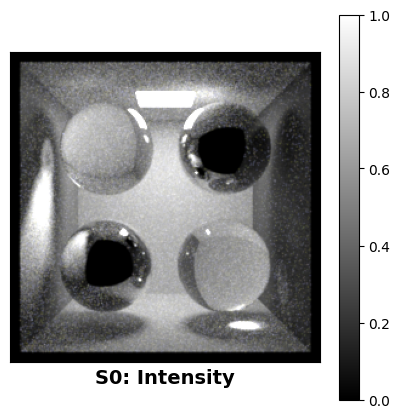

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.imshow(channels['S0'].convert(srgb_gamma=True), cmap='gray')
plt.colorbar()
plt.xticks([]); plt.yticks([])
plt.xlabel("S0: Intensity", size=14, weight='bold')
plt.show()

For the three Stokes vector components that encode the polarization state, we use a divergent colormap (`coolwarm`) as there are both positive and negative values to be displayed.

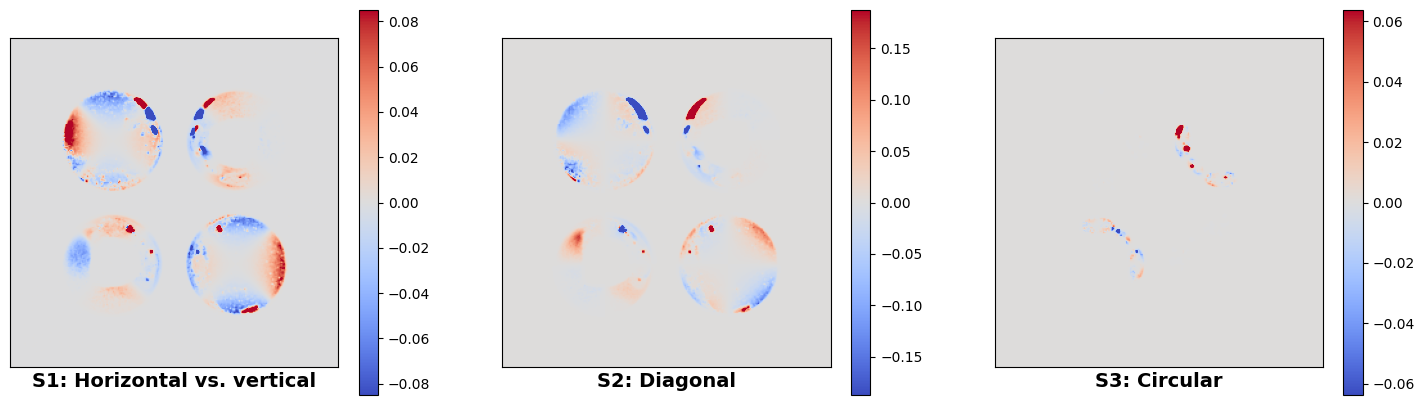

In [8]:
def plot_stokes_component(ax, image):
    # Convert the image into a TensorXf for manipulation 
    data = mi.TensorXf(image)[:, :, 0]
    plot_minmax = 0.05 * max(dr.max(data, axis=None), dr.max(-data, axis=None)).array[0] # Arbitrary scale for colormap
    img = ax.imshow(data, cmap='coolwarm', vmin=-plot_minmax, vmax=+plot_minmax)
    ax.set_xticks([]); ax.set_yticks([])
    return img
    
    
fig, ax = plt.subplots(ncols=3, figsize=(18, 5))
img = plot_stokes_component(ax[0], channels['S1'])
plt.colorbar(img, ax=ax[0])
img = plot_stokes_component(ax[1], channels['S2'])
plt.colorbar(img, ax=ax[1])
img = plot_stokes_component(ax[2], channels['S3'])
plt.colorbar(img, ax=ax[2])

ax[0].set_xlabel("S1: Horizontal vs. vertical", size=14, weight='bold')
ax[1].set_xlabel("S2: Diagonal", size=14, weight='bold')
ax[2].set_xlabel("S3: Circular", size=14, weight='bold')

plt.show()

## Standard visualizations for polarization

Mitsuba 3 additionally ships with a command line tool that implements the paper ["A Standardised Polarisation Visualisation for Images" by Wilkie and Weidlich][1]. This can be used to produce many more interesting false-color visualizations in this style automatically from these multi-channel Stokes vector images.

The tool can be run with:
```
python3 -m mitsuba.polvis
```
Please see the corresponding help text and the paper for more details.

[1]: https://cgg.mff.cuni.cz/~wilkie/Website/Home_files/polvis_sccg_2010.pdf

---

You now know the basics of how to render images in Mitsuba 3 that include additional polarization information. 🕶

## See also

- [Polarization][1]
- [Stokes integrator][2]

[1]: https://mitsuba.readthedocs.io/en/latest/src/key_topics/polarization.html
[2]: https://mitsuba.readthedocs.io/en/latest/src/generated/plugins_integrators.html#stokes-vector-integrator-stokes